In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression
# TensorFlow/Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
#Download Stock Data
stock_data = yf.Ticker('^GSPC').history(start='2010-01-01', end='2024-01-01')
stock_data['Date'] = stock_data.index
stock_data.to_csv('gspc_Data.csv', index=False)
#Add Features
stock_data['Day_of_Week'] = stock_data['Date'].dt.dayofweek
stock_data['Month'] = stock_data['Date'].dt.month
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Volume_Change'] = stock_data['Volume'].pct_change()
stock_data['Tomorrow'] = stock_data['Close'].shift(-1)  # Target: Next day's close price

# Create Lag Features
for lag in range(1, 6):
    stock_data[f'Close_Lag_{lag}'] = stock_data['Close'].shift(lag)
# Drop NaN values (lagging causes NaNs)
stock_data.dropna(inplace=True)

In [53]:
#Load and Clean GDP Data
gdp_data = pd.read_csv('API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2.csv', skiprows=4)

# Keep only relevant columns
gdp_data = gdp_data[['Country Name'] + [str(year) for year in range(2010, 2024)]]

# Filter for the United States
gdp_data = gdp_data[gdp_data['Country Name'] == 'United States']

# Reshape data from wide to long format
gdp_data = gdp_data.melt(id_vars=['Country Name'], var_name='Year', value_name='GDP')

# Convert 'Year' to integer and clean NaN
gdp_data['Year'] = pd.to_numeric(gdp_data['Year'], errors='coerce')
gdp_data.dropna(subset=['Year'], inplace=True)
gdp_data['Year'] = gdp_data['Year'].astype(int)

#Merge Stock Data with GDP Data
stock_data['Year'] = stock_data['Year'].astype(int)
merged_data = pd.merge(stock_data, gdp_data[['Year', 'GDP']], on='Year', how='left')

# Drop rows with NaN values after merging
merged_data.dropna(inplace=True)
merged_data.to_csv('merged_stock_gdp.csv', index=False)
print(merged_data)

             Open         High          Low        Close      Volume  \
0     1145.959961  1149.739990  1142.020020  1146.979980  4255780000   
1     1143.810059  1143.810059  1131.770020  1136.219971  4716160000   
2     1137.310059  1148.400024  1133.180054  1145.680054  4170360000   
3     1145.680054  1150.410034  1143.800049  1148.459961  3915200000   
4     1147.719971  1147.770020  1131.390015  1136.030029  4758730000   
...           ...          ...          ...          ...         ...   
3511  4724.290039  4748.709961  4708.350098  4746.750000  3431180000   
3512  4753.919922  4772.939941  4736.770020  4754.629883  3046770000   
3513  4758.859863  4784.720215  4758.450195  4774.750000  2513910000   
3514  4773.450195  4785.390137  4768.899902  4781.580078  2748450000   
3515  4786.439941  4793.299805  4780.979980  4783.350098  2698860000   

      Dividends  Stock Splits                      Date  Day_of_Week  Month  \
0           0.0           0.0 2010-01-11 00:00:00-05:00 

In [57]:
#Predictors and target
# predictors = ['Close', 'Volume', 'Open', 'High', 'Low', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5', 'GDP']
predictors = ['Close', 'Volume', 'Open', 'High', 'Low',
              'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3',
              'Close_Lag_4', 'Close_Lag_5', 'GDP',
              'Day_of_Week', 'Month']

target = 'Tomorrow'

#Split into train/test sets
train = merged_data.iloc[:-100]
test = merged_data.iloc[-100:]

# Extract predictors (X) and target (y)
X_train = train[predictors].values
y_train = train[target].values
X_test = test[predictors].values
y_test = test[target].values

# Scale data using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Feedforward Neural Network**


Training Feedforward Neural Network...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7338461.5000 - mae: 2498.6145 - val_loss: 17637252.0000 - val_mae: 4197.0020
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5644656.5000 - mae: 2191.9224 - val_loss: 4890408.0000 - val_mae: 2208.4873
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1119740.0000 - mae: 926.0117 - val_loss: 36987.1094 - val_mae: 158.2764
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43027.4844 - mae: 169.5611 - val_loss: 71667.8672 - val_mae: 226.2559
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39398.5352 - mae: 161.6472 - val_loss: 71563.1953 - val_mae: 227.6518
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35748.3945 - mae: 153.1607 - val_loss: 68133.0312 - val_mae: 223.1263
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34187.8281 - mae: 148.9491 - val_loss: 62771.7891 - val_mae: 215.0971
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 31828.2891 - mae: 143.6594

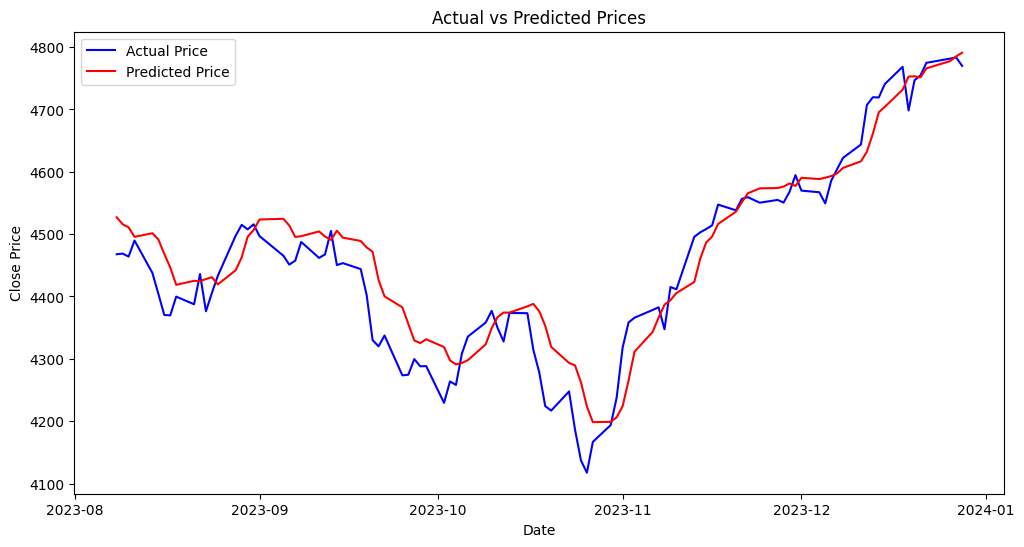

In [65]:
# Build the Feedforward Neural Network
print("Training Feedforward Neural Network...")

fnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

fnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
fnn_history = fnn_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=1
)

# Evaluate the model
y_pred = fnn_model.predict(X_test)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"FNN Mean Squared Error: {mse:.2f}")
print(f"FNN Mean Absolute Error: {mae:.2f}")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test, label='Actual Price', color='blue')
plt.plot(test['Date'], y_pred, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


**RNN model**

Training RNN...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 7227077.0000 - mae: 2481.0393 - val_loss: 19340578.0000 - val_mae: 4395.0229
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6853340.0000 - mae: 2411.4927 - val_loss: 15950895.0000 - val_mae: 3991.2935
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5218606.5000 - mae: 2105.0640 - val_loss: 8072121.5000 - val_mae: 2838.7346
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2376542.7500 - mae: 1419.7174 - val_loss: 1364453.1250 - val_mae: 1161.6582
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 420234.9688 - mae: 579.1779 - val_loss: 25461.0273 - val_mae: 130.8286
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50973.6367 - mae: 183.1442 - val_loss: 62284.4844 - val_mae: 208.4510
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40559.8086 - mae: 163.9776 - val_loss: 69823.1641 - val_mae: 223.1550
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 377

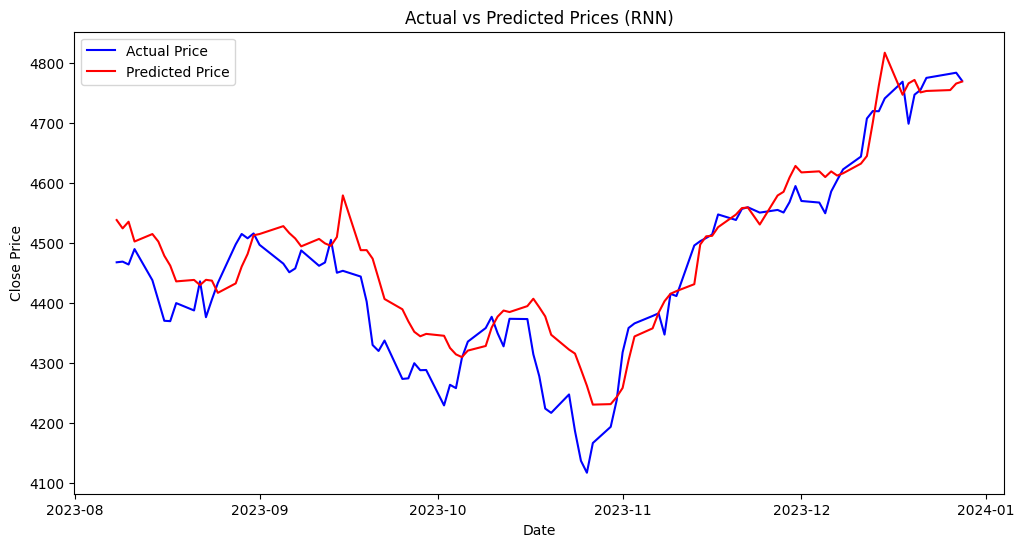

In [66]:
from tensorflow.keras.layers import SimpleRNN
#Split into Train/Test Sets
train = merged_data.iloc[:-100]
test = merged_data.iloc[-100:]

# Reshape Data for RNN (samples, time steps, features)
X_train_rnn = train[predictors].values
y_train_rnn = train[target].values
X_test_rnn = test[predictors].values
y_test_rnn = test[target].values

# Reshape input data for RNN: (samples, time_steps, features)
X_train_rnn = X_train_rnn.reshape((X_train_rnn.shape[0], 1, X_train_rnn.shape[1]))
X_test_rnn = X_test_rnn.reshape((X_test_rnn.shape[0], 1, X_test_rnn.shape[1]))

# Scale Data
scaler = MinMaxScaler()
X_train_rnn = scaler.fit_transform(X_train_rnn.reshape(-1, X_train_rnn.shape[-1])).reshape(X_train_rnn.shape)
X_test_rnn = scaler.transform(X_test_rnn.reshape(-1, X_test_rnn.shape[-1])).reshape(X_test_rnn.shape)

# Build the RNN Model
print("Training RNN...")

rnn_model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)  # Linear activation for regression
])

rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the Model
rnn_history = rnn_model.fit(
    X_train_rnn, y_train_rnn,
    epochs=50,
    validation_data=(X_test_rnn, y_test_rnn),
    batch_size=32,
    verbose=1
)

# Evaluate the Model
y_pred_rnn = rnn_model.predict(X_test_rnn)

# Mean Squared Error
mse = mean_squared_error(y_test_rnn, y_pred_rnn)
mae = mean_absolute_error(y_test_rnn, y_pred_rnn)
print(f"RNN Mean Squared Error: {mse:.2f}")
print(f"RNN Mean Absolute Error: {mae:.2f}")

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test_rnn, label='Actual Price', color='blue')
plt.plot(test['Date'], y_pred_rnn, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Prices (RNN)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# **Other algorithms: Linear Regression, SVM, Decision Tree, Random Forest**




Linear Regression Mean Squared Error: 1167.71
Linear Regression Mean Absolute Error: 26.60
SVM Mean Squared Error: 3085.82
SVM Mean Absolute Error: 45.95
Decision Tree Mean Squared Error: 3649.04
Decision Tree Mean Absolute Error: 46.51
Random Forest Mean Squared Error: 1505.31
Random Forest Mean Absolute Error: 31.54
FNN Mean Squared Error: 2842.52
RNN Mean Absolute Error: 42.09
RNN Mean Squared Error: 3904.84
RNN Mean Absolute Error: 48.54


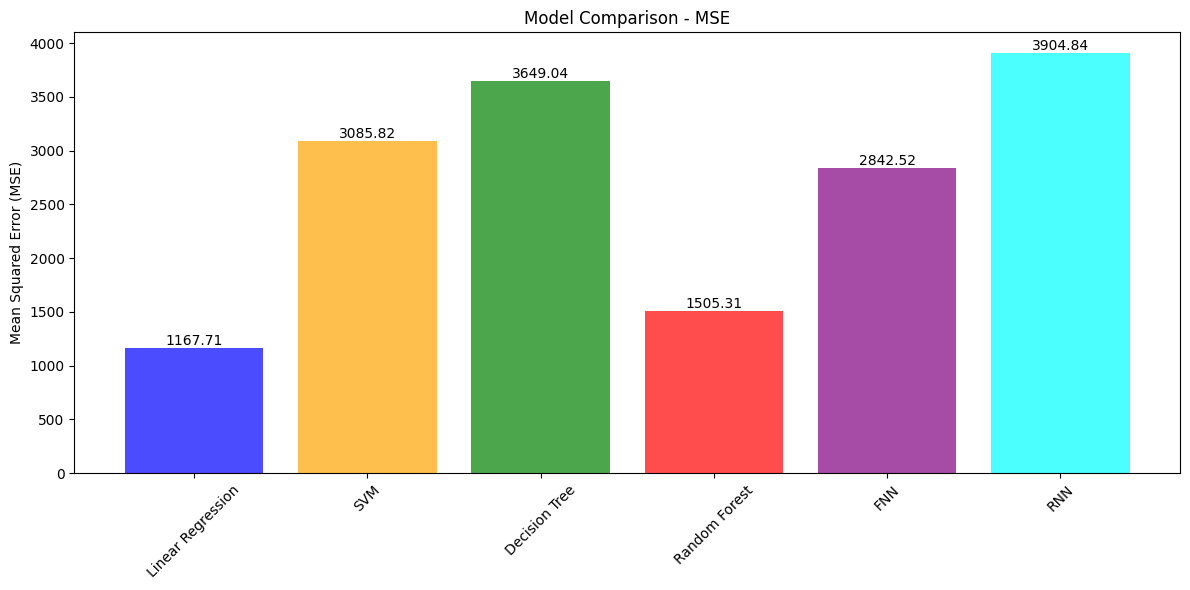

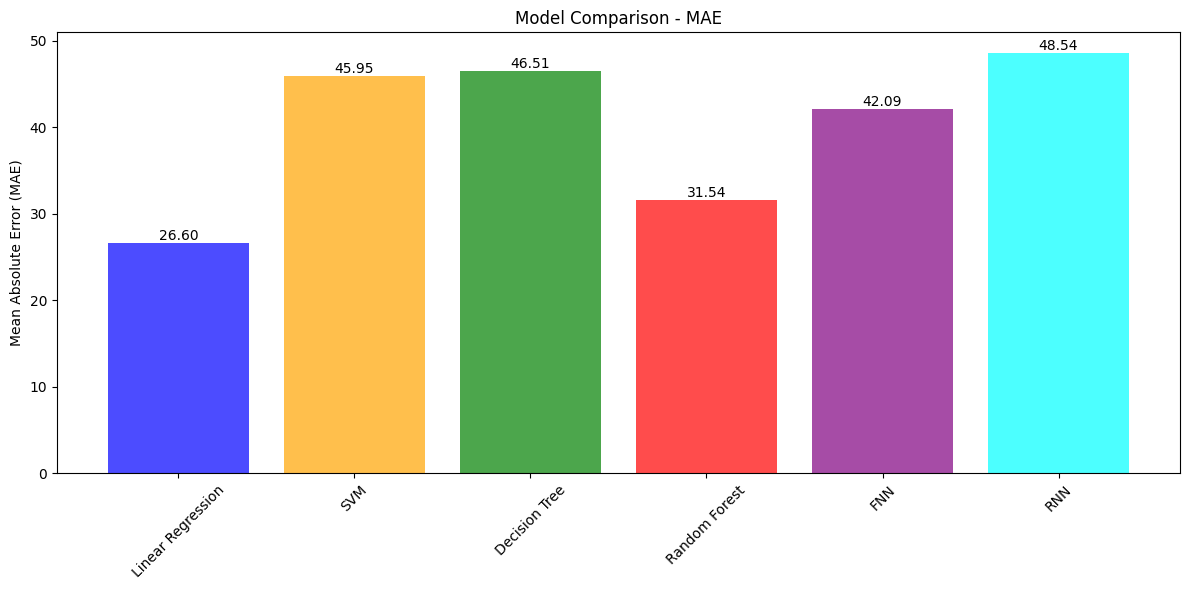

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# SVM
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Decision Tree
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluate models with MSE and MAE
lr_mse = mean_squared_error(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)
print(f"Linear Regression Mean Squared Error: {lr_mse:.2f}")
print(f"Linear Regression Mean Absolute Error: {lr_mae:.2f}")

svm_mse = mean_squared_error(y_test, svm_pred)
svm_mae = mean_absolute_error(y_test, svm_pred)
print(f"SVM Mean Squared Error: {svm_mse:.2f}")
print(f"SVM Mean Absolute Error: {svm_mae:.2f}")

dt_mse = mean_squared_error(y_test, dt_pred)
dt_mae = mean_absolute_error(y_test, dt_pred)
print(f"Decision Tree Mean Squared Error: {dt_mse:.2f}")
print(f"Decision Tree Mean Absolute Error: {dt_mae:.2f}")

rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
print(f"Random Forest Mean Squared Error: {rf_mse:.2f}")
print(f"Random Forest Mean Absolute Error: {rf_mae:.2f}")

fnn_mse = mean_squared_error(y_test, y_pred)
fnn_mae = mean_absolute_error(y_test, y_pred)
print(f"FNN Mean Squared Error: {fnn_mse:.2f}")
print(f"RNN Mean Absolute Error: {fnn_mae:.2f}")

rnn_mse = mean_squared_error(y_test_rnn, y_pred_rnn)
rnn_mae = mean_absolute_error(y_test_rnn, y_pred_rnn)
print(f"RNN Mean Squared Error: {rnn_mse:.2f}")
print(f"RNN Mean Absolute Error: {rnn_mae:.2f}")

# Store results
models = ['Linear Regression', 'SVM', 'Decision Tree', 'Random Forest', 'FNN', 'RNN']
mse_values = [lr_mse, svm_mse, dt_mse, rf_mse, fnn_mse, rnn_mse]
mae_values = [lr_mae, svm_mae, dt_mae, rf_mae, fnn_mae, rnn_mae]

# Plot MSE
plt.figure(figsize=(12, 6))
bars = plt.bar(models, mse_values, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan'], alpha=0.7)
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Comparison - MSE')
plt.xticks(rotation=45)

# Add value labels on top of each bar
for bar, value in zip(bars, mse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# Plot MAE
plt.figure(figsize=(12, 6))
bars = plt.bar(models, mae_values, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan'], alpha=0.7)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model Comparison - MAE')
plt.xticks(rotation=45)

# Add value labels on top of each bar
for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()


# **OVERFITTING**

**Feedforward Neural Network**


Training Feedforward Neural Network...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6472103.0000 - mae: 2333.7039 - val_loss: 130835.4922 - val_mae: 320.7680
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 237459.9531 - mae: 363.9740 - val_loss: 21737.4648 - val_mae: 122.7073
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 204175.0625 - mae: 345.8810 - val_loss: 18224.8691 - val_mae: 110.0760
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 183324.4219 - mae: 327.4071 - val_loss: 13398.6064 - val_mae: 92.8741
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 166946.8281 - mae: 312.0395 - val_loss: 15387.6426 - val_mae: 101.3637
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 150528.4844 - mae: 291.7337 - val_loss: 10583.1875 - val_mae: 85.6934
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 161206.5156 - mae: 296.7492 - val_loss: 5904.9814 - val_mae: 57.6474
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 161895.6875 - mae: 296.3076 - val_

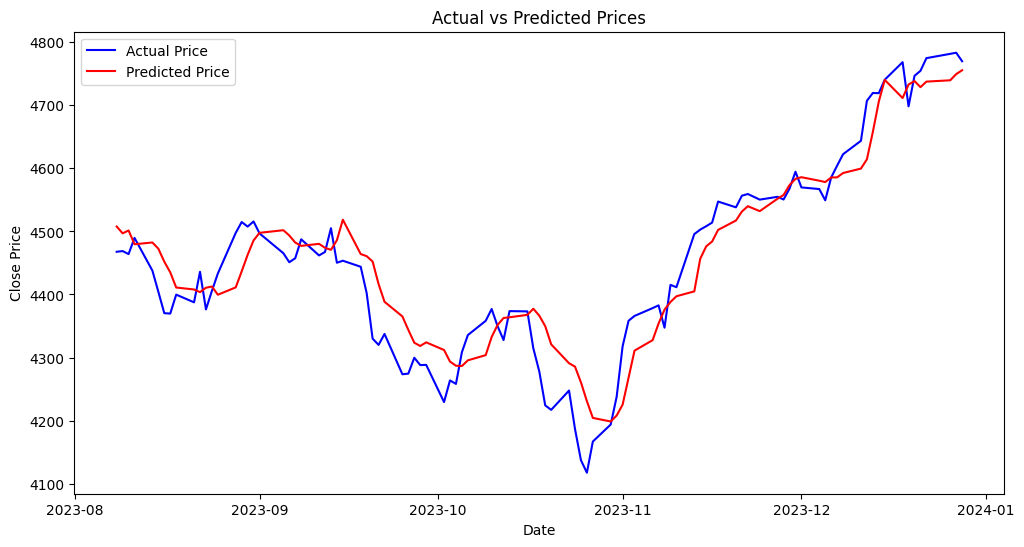

In [68]:
# Build the Feedforward Neural Network
print("Training Feedforward Neural Network...")

fnn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

fnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
fnn_history = fnn_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model
y_pred = fnn_model.predict(X_test)

# Mean Squared Error
msefnn = mean_squared_error(y_test, y_pred)
maefnn = mean_absolute_error(y_test, y_pred)
print(f"FNN Mean Squared Error: {msefnn:.2f}")
print(f"RNN Mean Absolute Error: {maefnn:.2f}")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test, label='Actual Price', color='blue')
plt.plot(test['Date'], y_pred, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

**RNN**


Training RNN...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7188695.0000 - mae: 2478.2053 - val_loss: 18866312.0000 - val_mae: 4340.7949
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6378015.5000 - mae: 2331.6174 - val_loss: 11685363.0000 - val_mae: 3415.9531
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3377908.5000 - mae: 1680.0248 - val_loss: 1716438.1250 - val_mae: 1304.0895
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 593720.0625 - mae: 632.5757 - val_loss: 25694.1699 - val_mae: 133.6165
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 259338.2188 - mae: 391.9637 - val_loss: 28338.1270 - val_mae: 141.2491
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 274835.3750 - mae: 397.4304 - val_loss: 39169.5234 - val_mae: 162.5107
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 259366.9844 - mae: 391.3061 - val_loss: 21763.0293 - val_mae: 123.5130
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 256852

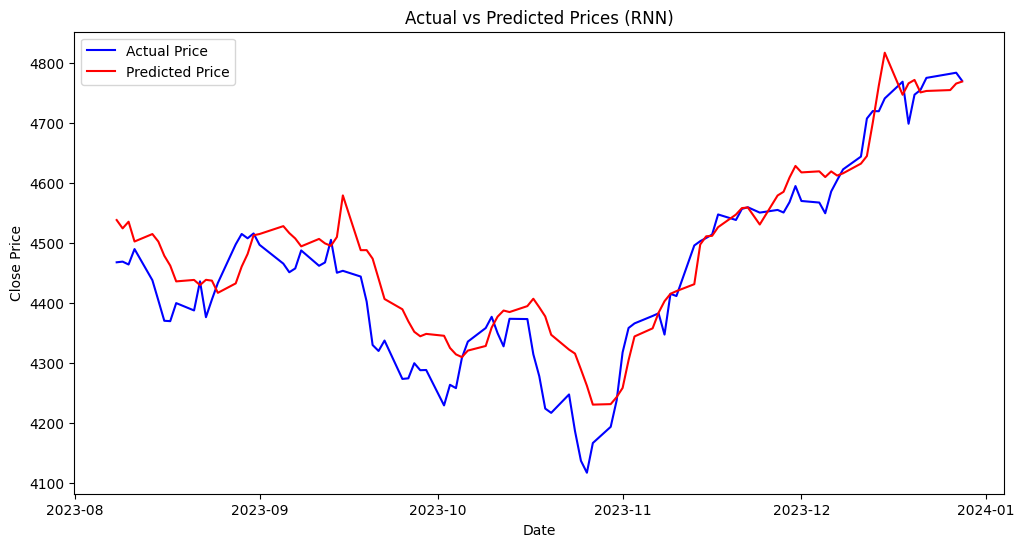

In [69]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
# Split into Train/Test Sets
train = merged_data.iloc[:-100]
test = merged_data.iloc[-100:]

# Reshape Data for RNN (samples, time steps, features)
X_train_rnn = train[predictors].values
y_train_rnn = train[target].values
X_test_rnn = test[predictors].values
y_test_rnn = test[target].values

# Reshape input data for RNN: (samples, time_steps, features)
X_train_rnn = X_train_rnn.reshape((X_train_rnn.shape[0], 1, X_train_rnn.shape[1]))
X_test_rnn = X_test_rnn.reshape((X_test_rnn.shape[0], 1, X_test_rnn.shape[1]))

# Scale Data
scaler = MinMaxScaler()
X_train_rnn = scaler.fit_transform(X_train_rnn.reshape(-1, X_train_rnn.shape[-1])).reshape(X_train_rnn.shape)
X_test_rnn = scaler.transform(X_test_rnn.reshape(-1, X_test_rnn.shape[-1])).reshape(X_test_rnn.shape)

# Build the RNN Model
print("Training RNN...")

rnn_model = Sequential([
    SimpleRNN(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Train the Model
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
rnn_history = rnn_model.fit(
    X_train_rnn, y_train_rnn,
    epochs=50,
    validation_data=(X_test_rnn, y_test_rnn),
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the Model
msernn = mean_squared_error(y_test_rnn, y_pred_rnn)
maernn = mean_absolute_error(y_test_rnn, y_pred_rnn)

# Print results
print(f"RNN Mean Squared Error: {msernn:.2f}")
print(f"RNN Mean Absolute Error: {maernn:.2f}")

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test_rnn, label='Actual Price', color='blue')
plt.plot(test['Date'], y_pred_rnn, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Prices (RNN)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

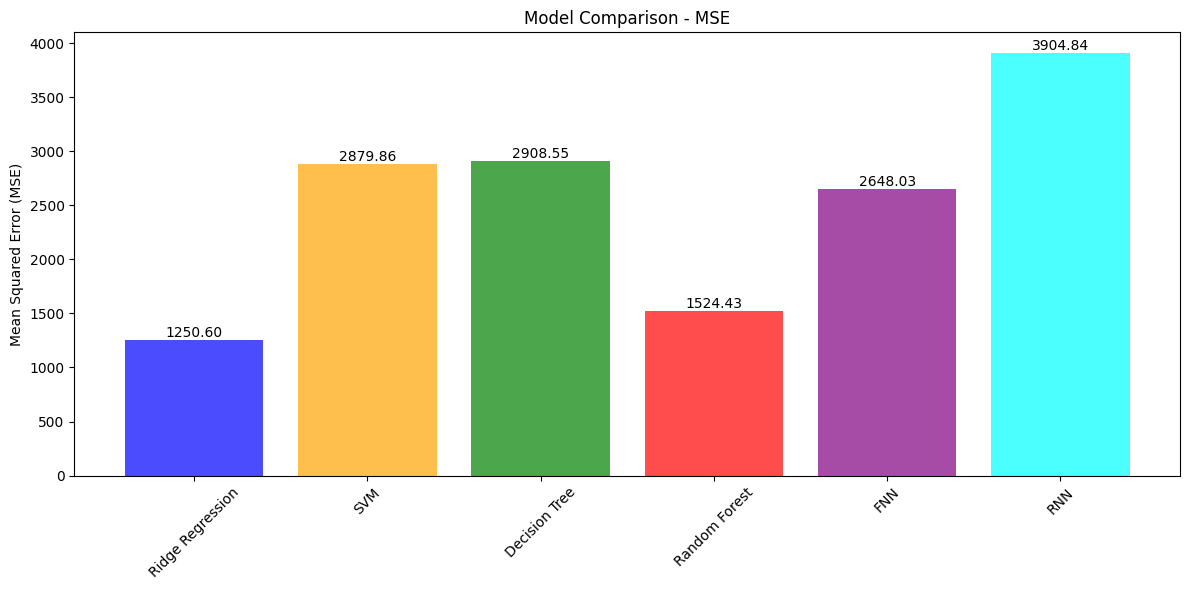

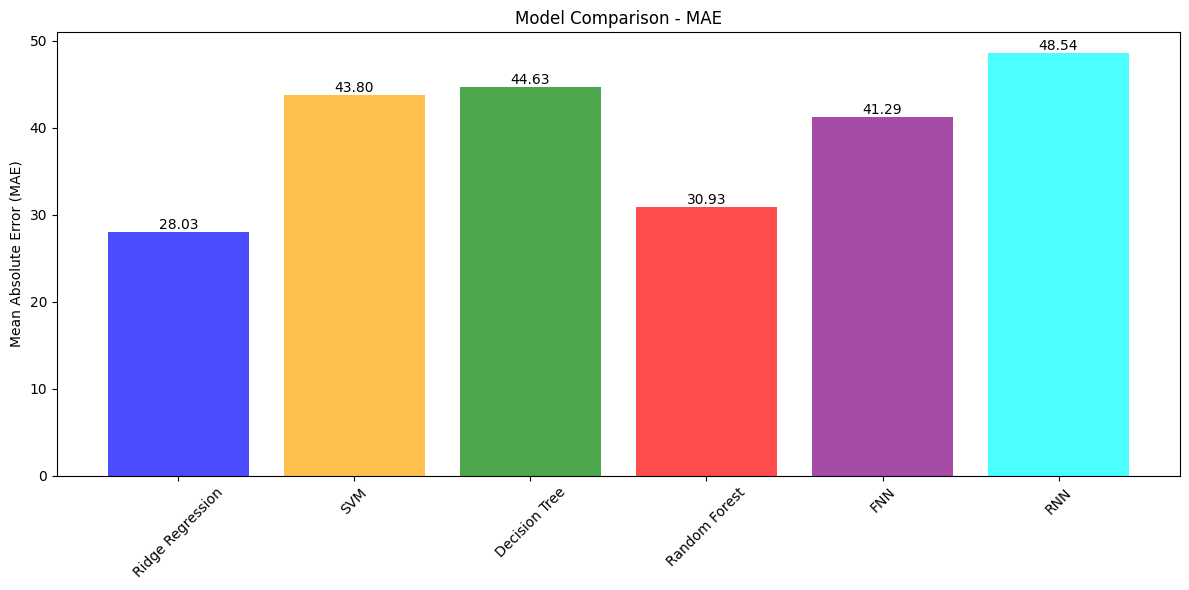

In [70]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge Regression
lr_model = Ridge(alpha=1.0)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# SVM
svm_model = SVR(kernel='linear', C=0.1)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

# Decision Tree
dt_model = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(max_depth=10, n_estimators=50, max_features='sqrt', random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluate FNN and RNN
fnn_mseov = msefnn
fnn_maeov = maefnn

rnn_mseov = msernn
rnn_maeov = maernn

# Evaluate other models with MSE and MAE
mse_values = [
    mean_squared_error(y_test, lr_pred),
    mean_squared_error(y_test, svm_pred),
    mean_squared_error(y_test, dt_pred),
    mean_squared_error(y_test, rf_pred),
    fnn_mseov,
    rnn_mseov
]

mae_values = [
    mean_absolute_error(y_test, lr_pred),
    mean_absolute_error(y_test, svm_pred),
    mean_absolute_error(y_test, dt_pred),
    mean_absolute_error(y_test, rf_pred),
    fnn_maeov,
    rnn_maeov
]

models = ['Ridge Regression', 'SVM', 'Decision Tree', 'Random Forest', 'FNN', 'RNN']

# Plot MSE
plt.figure(figsize=(12, 6))
bars = plt.bar(models, mse_values, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan'], alpha=0.7)
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Comparison - MSE')
plt.xticks(rotation=45)

# Add value labels to each bar
for bar, value in zip(bars, mse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# Plot MAE
plt.figure(figsize=(12, 6))
bars = plt.bar(models, mae_values, color=['blue', 'orange', 'green', 'red', 'purple', 'cyan'], alpha=0.7)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model Comparison - MAE')
plt.xticks(rotation=45)

# Add value labels to each bar
for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{value:.2f}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()
